# Import

In [1]:
data_path='data/'
api_key='ehlVSIKSMiugJZHlii3sU7OKCexe4MIlnYenGric'
import pandas as pd 
import numpy as np
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Analysis

## Take  a look on dataset

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(f"{data_path}epi_r.csv")
for name, count in df.nunique().items():
    print(f"{name}: {count}")

KeyboardInterrupt: 

The dataset have target feature:
```rating```.

There is also features: ```title, calories, protein, fat, sodium```



Dataset have 2 categorical features after the One-Hot Encoding conversion.

first categorical feature is:

Ingredients: ```almond, anchovy, apple, avocado, bacon```

second categorical feature is tags

The tags may contain:
* Recipe characteristics: ```#cakeweek, #wasteless, 22-minute meals, 3-ingredient recipes...```

* Geographical affiliation: ```alabama, arizona, boston, france, italy...```

* Dietary restrictions and features: ```dairy free, gluten free, vegan...```

* Cooking methods: ```bake, boil, grill, slow cooker...```

* Holidays and events: ```christmas, halloween, valentine's day...```

* Machinery and tools: ```blender, food processor, pressure cooker, microwave...```

## Let's sort columns in the dataset, and get nutrients for ingredients

### this is list of nutrients, what we need

In [ ]:
nutrients_list = [
    # Основные макронутриенты 
    "Total lipid (fat)",
    "Fatty acids, total saturated",
    "Fatty acids, total monounsaturated",
    "Fatty acids, total polyunsaturated",
    "Fatty acids, total trans",
    "Cholesterol",
    "Carbohydrate, by difference",
    "Sodium, Na", 
    "Fiber, total dietary",
    "Protein",
    "Sugars, Total",  
    "Energy", 
    "Vitamin A, RAE",  
    "Vitamin C, total ascorbic acid", 
    "Vitamin D (D2 + D3)",
    "Vitamin E (alpha-tocopherol)",
    "Vitamin K (phylloquinone)",
    "Thiamin",
    "Riboflavin",
    "Niacin",
    "Vitamin B-6",
    "Folate, total",
    "Vitamin B-12",
    
    # Минералы
    "Calcium, Ca",
    "Iron, Fe",
    "Phosphorus, P",
    "Magnesium, Mg",
    "Zinc, Zn",
    "Copper, Cu",
    "Manganese, Mn",
    "Selenium, Se",
    "Potassium, K",
    
    # Специфичные компоненты 
    "Ash",
    "Nitrogen",
    "Water",
    
    # Разные формы сахаров
    "Fructose",
    "Glucose",
    "Sucrose",
    "Galactose"
]


### Funcs for primary sort ingredients and get cache for nutrients 

In [ ]:
import requests
import json
def load_nutrients_cache(path_to_file):
    try:
        with open(path_to_file, 'r', encoding='utf-8') as f:
            try:
                return json.load(f)
            except:
                return {}
    except:
        return {}
def save_to_cache(path_to_file, ingredient, nutrient_dict, cache):
    cache[ingredient]=nutrient_dict
    with open(path_to_file, 'w', encoding='utf-8') as f:
        json.dump(cache, f, indent=4, ensure_ascii=False)

def get_nutrients_info(ingredient):
    ingredient_info=None
    params = {
        "query": f'"{ingredient}"',
        "api_key": api_key,
        "dataType": ["Foundation"]  
    }
    cache=load_nutrients_cache(f"{data_path}ingridient_nutr_cache.json")
    non_ingredient_cache=load_nutrients_cache(f"{data_path}not_ingridient_cache.json")
    if ingredient in cache:
        return cache[ingredient]
    elif ingredient not in non_ingredient_cache:
        response = requests.get('https://api.nal.usda.gov/fdc/v1/foods/search', params=params)
        if response.status_code == 200:
            ingredient_info = response.json().get('foods')
            if ingredient_info and ingredient_info[0].get('score') < 200:
                ingredient_info=None
            if ingredient_info:
                ingredient_info=ingredient_info[0].get('foodNutrients')
                nutrient_df=pd.json_normalize(ingredient_info)[['nutrientName','unitName','value']]
                nutrient_dict=nutrient_df[nutrient_df['nutrientName'].isin(nutrients_list)].to_dict()       
                save_to_cache(f"{data_path}ingridient_nutr_cache.json",ingredient, nutrient_dict, cache)
    if not ingredient_info:
        save_to_cache(f"{data_path}not_ingridient_cache.json",ingredient, ingredient_info, non_ingredient_cache)
    return ingredient_info
def is_ingredient(ingredient):
    data=get_nutrients_info(ingredient)
    return True if data else False


In [ ]:
features =[]
for column in df.columns:
    for ingredients in column.split("/"):
        if is_ingredient(ingredients):
            features.append(column)
            break
print("a list of possible ingredients")
print (features)


a list of possible ingredients
['fat', 'sodium', 'almond', 'apple', 'apple juice', 'apricot', 'arugula', 'asparagus', 'avocado', 'bacon', 'banana', 'barley', 'bean', 'beef', 'beef tenderloin', 'beet', 'blackberry', 'blueberry', 'boil', 'bok choy', 'braise', 'bran', 'bread', 'breakfast', 'broccoli', 'broil', 'brussel sprout', 'bulgur', 'butter', 'buttermilk', 'cabbage', 'cantaloupe', 'carrot', 'cashew', 'cauliflower', 'celery', 'cheddar', 'cherry', 'chestnut', 'chicken', 'chickpea', 'cobbler/crumble', 'coconut', 'cod', 'cookie', 'cookies', 'corn', 'cottage cheese', 'crab', 'cranberry', 'cream cheese', 'cucumber', 'dill', 'egg', 'eggplant', 'fat free', 'feta', 'fig', 'fish', 'garlic', 'grains', 'grape', 'grapefruit', 'green onion/scallion', 'ham', 'hazelnut', 'hominy/cornmeal/masa', 'honeydew', 'hummus', 'kale', 'kiwi', 'kosher', 'lamb', 'leek', 'lentil', 'lettuce', 'low fat', 'low/no sugar', 'macadamia nut', 'mango', 'meat', 'melon', 'milk/cream', 'monterey jack', 'mozzarella', 'mushroo

In [ ]:
non_ingreedients = []
for column in df.columns:
    for non_ingreedient in column.split("/"):
        if not is_ingredient(non_ingreedient):
            non_ingreedients.append(column)
            break
print("a list of possible non ingredients")
print (non_ingreedients)


a list of possible non ingredients
['title', 'rating', 'calories', 'protein', '#cakeweek', '#wasteless', '22-minute meals', '3-ingredient recipes', '30 days of groceries', 'advance prep required', 'alabama', 'alaska', 'alcoholic', 'amaretto', 'anchovy', 'anise', 'anniversary', 'anthony bourdain', 'aperitif', 'appetizer', 'arizona', 'artichoke', 'asian pear', 'aspen', 'atlanta', 'australia', 'back to school', 'backyard bbq', 'bake', 'basil', 'bass', 'bastille day', 'beef rib', 'beef shank', 'beer', 'bell pepper', 'berry', 'beverly hills', 'birthday', 'biscuit', 'bitters', 'blender', 'blue cheese', 'bon appétit', 'bon app��tit', 'boston', 'bourbon', 'brandy', 'breadcrumbs', 'brie', 'brine', 'brisket', 'broccoli rabe', 'brooklyn', 'brown rice', 'brownie', 'brunch', 'buffalo', 'buffet', 'bulgaria', 'burrito', 'butternut squash', 'butterscotch/caramel', 'cake', 'california', 'calvados', 'cambridge', 'campari', 'camping', 'canada', 'candy', 'candy thermometer', 'capers', 'caraway', 'cardamom

This API method doesn't work very well, so we'll sort the features manually.

remove non_ingredients from features

In [ ]:
non_ingredients = [
    'fat',               
    'sodium',            
    'boil',              
    'braise',            
    'broil',            
    'breakfast',        
    'cobbler/crumble',  
    'cookie',           
    'cookies',        
    'fat free',        
    'kosher',      
    'low fat',          
    'low/no sugar',    
    'no sugar added',   
    'no-cook',     
    'raw',             
    'stuffing/dressing',
    'summer',       
    'winter',         
    'wheat/gluten-free'
]
for value in non_ingredients:
    if value in features:
        if value not in df.columns:
            print(f"problem with: {value}")
        features.remove(value)

add actually ingredients from dataset to features

In [ ]:
actually_ingredients=actually_ingredients = [
    'anchovy', 'anise', 'apple juice', 'artichoke',
    'asian pear', 'basil', 'bass', 'beef rib',
    'beef shank', 'beer', 'bell pepper', 'berry',
    'bitters', 'blue cheese', 'brie', 'brisket',
    'broccoli rabe', 'brown rice', 'brownie', 'butternut squash',
    'butterscotch/caramel', 'cake', 'calvados', 'capers',
    'caraway', 'cardamom', 'caviar', 'chard',
    'cheese', 'chile', 'chile pepper', 'chili',
    'chive', 'chocolate', 'cilantro', 'cinnamon',
    'citrus', 'clam', 'clove', 'coffee',
    'collard greens', 'cornmeal', 'couscous', 'cranberry sauce',
    'crêpe', 'currant', 'curry', 'custard',
    'date', 'dried fruit', 'duck', 'egg nog',
    'endive', 'escarole', 'fennel', 'flat bread',
    'fontina', 'fruit juice', 'ginger', 'goat cheese',
    'goose', 'gouda', 'granola', 'green bean',
    'ground beef', 'ground lamb', 'guava', 'halibut',
    'hamburger', 'herb', 'hominy/cornmeal/masa', 'honey',
    'horseradish', 'ice cream', 'iced coffee', 'iced tea',
    'jalapeño', 'jam or jelly', 'jerusalem artichoke', 'jícama',
    'kumquat', 'lamb chop', 'lamb shank', 'lasagna',
    'leafy green', 'legume', 'lemon', 'lemon juice',
    'lemongrass', 'lima bean', 'lime', 'lime juice',
    'lingonberry', 'lobster', 'macaroni and cheese', 'maple syrup',
    'mayonnaise', 'meatball', 'meatloaf', 'milk/cream',
    'mint', 'molasses', 'muffin', 'mussel',
    'mustard greens', 'noodle', 'nutmeg', 'octopus',
    'okra', 'omelet', 'oregano', 'orzo',
    'papaya', 'paprika', 'parsley', 'parsnip',
    'passion fruit', 'persimmon', 'phyllo/puff pastry dough', 'poblano',
    'pomegranate juice', 'poppy', 'pork rib', 'pork tenderloin',
    'pot pie', 'potato salad', 'prosciutto', 'quail',
    'quiche', 'quince', 'rabbit', 'rack of lamb',
    'radicchio', 'radish', 'rhubarb', 'rosemary',
    'rosé', 'rum', 'saffron', 'sage',
    'sake', 'salad dressing', 'sardine', 'scallop',
    'scotch', 'sesame oil', 'shellfish', 'sherry',
    'snapper', 'sorbet', 'soufflé/meringue', 'soup/stew',
    'sour cream', 'sourdough', 'soy sauce', 'spice',
    'squid', 'stock', 'stuffing/dressing', 'sugar snap pea',
    'sweet potato/yam', 'swiss cheese', 'swordfish', 'tamarind',
    'tangerine', 'tapioca', 'tarragon', 'tea',
    'tofu', 'tortillas', 'tree nut', 'triple sec',
    'tropical fruit', 'trout', 'turnip', 'vanilla',
    'veal', 'venison', 'vermouth', 'vinegar',
    'waffle', 'wasabi', 'watercress', 'watermelon',
    'white wine', 'wine', 'yellow squash', 'yuca'
]
for value in actually_ingredients:
    if value not in features:
        if value not in df.columns:
            print(f"problem with: {value}")
        features.append(value)


## lets sort columns in our dataset


In [ ]:
X=df[features]
y=df['rating']

In [ ]:
print(X.shape) 
print(y.shape) 

X.sum().sort_values(ascending=False)

(20052, 322)
(20052,)


onion         2238.0
tomato        2140.0
milk/cream    1995.0
egg           1768.0
herb          1681.0
               ...  
caviar           1.0
waffle           1.0
crêpe            1.0
quiche           1.0
sorbet           1.0
Length: 322, dtype: float64

visual

In [ ]:
y.value_counts()

rating
4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: count, dtype: int64

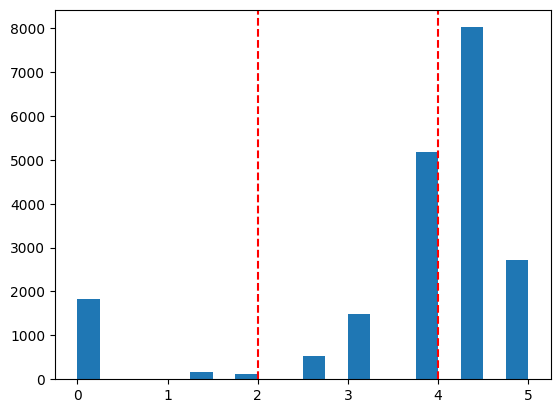

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y, bins=20)
plt.axvline(2, color='r', linestyle='--')  
plt.axvline(4, color='r', linestyle='--') 
plt.show()


## Let's start tuning the hyperparameters

это чисто препроцессинг, то что я сделал выше мб оформлю его так же шобы в пайплайн запихать 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

#### Train-test-validation split 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

class TrainValidationTest(BaseEstimator, TransformerMixin):
        def __init__(self, test_size=0.2, random_state=21, stratified=True):
            self.test_size = test_size
            self.random_state = random_state
            self.stratified = stratified
        def split(self, X , y):
            stratify = y if self.stratified else None
            X_train, X_test, y_train, y_test =train_test_split(
                X, y, test_size=self.test_size, random_state=self.random_state, stratify=stratify
            )
            X_train, X_valid, y_train, y_valid =train_test_split(
                X_train, y_train, test_size=self.test_size/(1-self.test_size), random_state=self.random_state, stratify=stratify
            )

            



            label_encoder= LabelEncoder()
            y_train=label_encoder.fit_transform(y_train)
            y_valid=label_encoder.fit_transform(y_valid)
            y_test=label_encoder.fit_transform(y_test)



            #since the data is not balanced, I will use SMOTE

            smote = SMOTE(sampling_strategy="auto", random_state=21)
            X_train, y_train = smote.fit_resample(X_train, y_train)
            

            return X_train, X_valid, X_test, y_train, y_valid, y_test

#### Model selection class


In [ ]:
from copy import deepcopy
from itertools import product
from sklearn.metrics import get_scorer
def manual_grid_search(X_train, y_train, X_valid, y_valid, model_estimator,param_grid, cv, scoring='accuracy_score',  n_jobs=-1, error_score=np.nan):
    res=[]
    estimator=deepcopy(model_estimator)
    total_combinations = np.prod([len(v) for v in param_grid.values()])
    # get scorer for valid score
    scorer = get_scorer(scoring)

    for params in tqdm(list(product(*param_grid.values())), total=total_combinations, desc="GridSearch"):

        current_model = deepcopy(estimator)
        current_model.set_params(**(dict(zip(param_grid.keys(), params))))
        try:
            score=cross_val_score(
                current_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=n_jobs,error_score=error_score
            )

            current_model.fit(X_train, y_train)
            valid_score=scorer(current_model, X_valid, y_valid)

            res.append({
                'train_score': score.mean(),
                'valid_score': valid_score,
                'params': dict(zip(param_grid.keys(), params))
            })


        except Exception as e:
            print(f"Error with params {params}: {str(e)}")
            res.append({
                **(dict(zip(param_grid.keys(), params))),
                'train_score': 'Na',
                'valid_score': 'Na'
            })
            continue
        
    return pd.DataFrame(res).sort_values('valid_score', ascending=False)
# I know I should have used a dict instead of model name, but I don't care.
class ModelSelection:
    def __init__ (self,estimators,estimators_name, grid_dict, scoring='accuracy_score'):
        self.estimators=estimators
        self.scoring=scoring
        self.estimators_name=estimators_name
        self.grid_dict=grid_dict
        self.results=pd.DataFrame()
        self.best_res=[]
    def choose(self,X_train, y_train, X_valid, y_valid, cv=2):
        """
        Method choose() takes X_train, y_train, X_valid, y_valid, optional cv, 
        and returns the name of the best model among all the models on the validation set
        """
        for estimator in self.estimators:
            model_name= self.estimators_name[self.estimators.index(estimator)]
            search_res=manual_grid_search(X_train,y_train,X_valid, y_valid,estimator,self.grid_dict[model_name], cv=cv, scoring=self.scoring)
            search_res['model']=model_name
            best_params = search_res.head(1)['params'].item()
            best_train_score = search_res.head(1)['train_score'].item()
            best_valid_score = search_res.head(1)['valid_score'].item()
            self.results=pd.concat([self.results, search_res], axis=0, ignore_index=True)
            self.best_res.append({
                'model': model_name,
                'params': best_params,
                'valid_score': best_valid_score,
                'train_score': best_train_score
            })
            
            print(f"Best params for model{model_name}: {best_params}")
            print(f"training score[{self.scoring}]: {best_train_score:.3f}")
            print(f"Best on validation set score[{self.scoring}]: {best_valid_score:.3f}")
        self.best_res=pd.DataFrame(self.best_res)
        self.best_res.sort_values('valid_score', ascending=False,inplace=True)
        best_model_name=self.best_res.head(1)['model'].item()
        print(f"\nBest model: {best_model_name}\nwith params: {self.best_res.head(1)['params'].item()}\nand score: {self.best_res.head(1)['valid_score'].item()}")
        return self.results.sort_values('valid_score', ascending=False)
    # def show_results(self):
        # return self.results.groupby(by="model").sort_values('valid_score', ascending=False)
    def fit_score(self,X_comb,y_comb, X_test, y_test):
        params=self.best_res.head(1)['params'].item()
        model_name=self.best_res.head(1)['model'].item()
        print(f'Taking model: {model_name} with params:{params}')
        best_estimator=self.estimators[self.estimators_name.index(model_name)]
        best_estimator.set_params(**(params))
        best_estimator.fit(X_comb,y_comb)
        scorer=get_scorer(self.scoring)
        print("the final score is :",(scorer(best_estimator,X_test,y_test)))        

In [ ]:
def fit_score(estimator, params, X_comb, y_comb, X_test, y_test, scoring='accuracy'):
        estimator.set_params(**(params))
        estimator.fit(X_comb,y_comb)
        scorer=get_scorer(scoring)
        print("the final score is :",(scorer(estimator,X_test,y_test)))  

# Regression serch params

In [ ]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


estimators = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    RandomForestRegressor(random_state=21, n_jobs=-1),
    GradientBoostingRegressor(random_state=21),
    XGBRegressor(random_state=21, n_jobs=-1)
]
manual_grid_search
estimators_name = [
    'LinearRegression',
    'Ridge',
    'Lasso',
    'ElasticNet',
    'RandomForest',
    'GradientBoosting',
    'XGBoost'
]

grid_dict = {
    'LinearRegression': {
        'fit_intercept': [True, False],
        'positive': [False]
    },
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0],  
        'solver': ['svd', 'cholesky', 'saga']  
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1.0],  
        'selection': ['cyclic']
    },
    'ElasticNet': {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.3, 0.5, 0.7] 
    },
    'RandomForest': {
        'n_estimators': [50,100, 200], 
        'max_depth': [15,30, None],  
        'min_samples_split': [2, 5,10],
        'max_features': ['sqrt']
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

Regression grid search


In [ ]:
scoring='neg_root_mean_squared_error'


splitter = TrainValidationTest(stratified=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitter.split(X, y)
search_parametrs= ModelSelection(estimators,estimators_name, grid_dict, scoring)
result_serching=search_parametrs.choose(X_train, y_train, X_valid, y_valid)


GridSearch:   0%|          | 0/2 [00:00<?, ?it/s]

Best params for modelLinearRegression: {'fit_intercept': True, 'positive': False}
training score[neg_root_mean_squared_error]: -1.339
Best on validation set score[neg_root_mean_squared_error]: -1.292


GridSearch:   0%|          | 0/9 [00:00<?, ?it/s]

Best params for modelRidge: {'alpha': 10.0, 'solver': 'cholesky'}
training score[neg_root_mean_squared_error]: -1.320
Best on validation set score[neg_root_mean_squared_error]: -1.282


GridSearch:   0%|          | 0/3 [00:00<?, ?it/s]

Best params for modelLasso: {'alpha': 0.01, 'selection': 'cyclic'}
training score[neg_root_mean_squared_error]: -1.346
Best on validation set score[neg_root_mean_squared_error]: -1.311


GridSearch:   0%|          | 0/9 [00:00<?, ?it/s]

Best params for modelElasticNet: {'alpha': 0.01, 'l1_ratio': 0.3}
training score[neg_root_mean_squared_error]: -1.332
Best on validation set score[neg_root_mean_squared_error]: -1.296


GridSearch:   0%|          | 0/27 [00:00<?, ?it/s]

Best params for modelRandomForest: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'max_features': 'sqrt'}
training score[neg_root_mean_squared_error]: -1.317
Best on validation set score[neg_root_mean_squared_error]: -1.271


GridSearch:   0%|          | 0/16 [00:00<?, ?it/s]

Best params for modelGradientBoosting: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0}
training score[neg_root_mean_squared_error]: -1.332
Best on validation set score[neg_root_mean_squared_error]: -1.276


GridSearch:   0%|          | 0/32 [00:00<?, ?it/s]

Best params for modelXGBoost: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0}
training score[neg_root_mean_squared_error]: -1.330
Best on validation set score[neg_root_mean_squared_error]: -1.273

Best model: RandomForest
with params: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'max_features': 'sqrt'}
and score: -1.271343441880819


In [ ]:
print("Calc score on the best model")

best_model_name = result_serching.iloc[0]['model']
best_estimator = estimators[estimators_name.index(best_model_name)]
params= result_serching.iloc[0]['params']
print(f'Taking model: {best_model_name} with params:{params}')
X_comb=pd.concat([X_train, X_valid], axis=0, ignore_index=True)
y_comb=pd.concat([y_train, y_valid], axis=0, ignore_index=True)

fit_score(best_estimator, params, X_comb,y_comb, X_test,y_test, scoring=scoring)

Calc score on the best model
Taking model: RandomForest with params:{'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'max_features': 'sqrt'}
the final score is : -1.260777480024706


let's analyze the results

In [ ]:
result_serching.head()

,train_score,valid_score,params,model
23,-1.317030,-1.271343,"{'n_estimators': 200, 'max_depth': 30, 'min_sa...",RandomForest
24,-1.317769,-1.271758,"{'n_estimators': 100, 'max_depth': 30, 'min_sa...",RandomForest
66,-1.329763,-1.273091,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",XGBoost
67,-1.327541,-1.273299,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",XGBoost
25,-1.319519,-1.273352,"{'n_estimators': 50, 'max_depth': 30, 'min_sam...",RandomForest


Lets take  RandomForest with params:{'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'max_features': 'sqrt'}
with the final score : -1.260777480024706

In [ ]:
RandomForestRegressor_model=RandomForestRegressor(random_state=21, n_jobs=-1)
RandomForestRegressor_model.set_params(**(result_serching.iloc[0]['params']))


RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, random_state=21)

lets try do model that classifays on regression purpose 

In [ ]:
def rating_to_сat(y):
    bins = [0, 2, 4, 6]
    labels = ['bad', 'so-so', 'great']
    return pd.cut(y, bins=bins, labels=labels).astype(str)
class RegressionToClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, regressor=None, bins=[0, 2, 4, 6], labels=['bad', 'so-so', 'great']):
        self.regressor = regressor if regressor is not None else RandomForestRegressor()
        self.bins = bins
        self.labels = labels
    
    def fit(self, X, y):
        self.regressor.fit(X, y)
        return self
    
    def predict(self, X):
        y_pred = self.regressor.predict(X)
        return pd.cut(y_pred, bins=self.bins, labels=self.labels, include_lowest=True)
    
    def predict_proba(self, X):
        raise NotImplementedError("predict_proba is not implemented for this classifier")
regresRegressionToClassifier = RegressionToClassifier(RandomForestRegressor_model)
regresRegressionToClassifier.fit(X_comb,y_comb)
y_test_classification=rating_to_сat(y_test)
y_pred=regresRegressionToClassifier.predict(X_test)
accuracy_score(y_test_classification,y_pred)


NameError: name 'RandomForestRegressor_model' is not defined

very low accuracy, we cant take those model

# classification

prepare data to classification

In [ ]:
from sklearn.metrics import classification_report
def closest_int(y):
    return y.round().astype(int)

scoring='accuracy'


splitter = TrainValidationTest(stratified=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitter.split(X, closest_int(y))
X_comb=pd.concat([X_train, X_valid], axis=0, ignore_index=True)
y_comb=np.concatenate([y_train, y_valid]) 
y_comb=pd.DataFrame(y_comb)

diffrent models variants

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

estimators = [
    RandomForestClassifier(random_state=21, n_jobs=-1),
    GradientBoostingClassifier(random_state=21),
    BaggingClassifier(random_state=21, n_jobs=-1),
    XGBClassifier(random_state=21, n_jobs=-1),
    CatBoostClassifier(random_state=21, verbose=0)
]

estimators_name = [
    'RandomForest',
    'GradientBoosting',
    'Bagging',
    'XGBoost',
    'CatBoost'
]

grid_dict = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', None]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    },
    'Bagging': {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.8, 1.0],
        'max_features': [0.5, 0.8, 1.0],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1]
    }
}

search best model

I took the precision_weighted metric because it minimizes false positives (for example, bad predicted as great).

In [ ]:
search_parametrs= ModelSelection(estimators,estimators_name, grid_dict, scoring='precision_weighted')
result_serching=search_parametrs.choose(X_train, y_train, X_valid, y_valid)

GridSearch:   0%|          | 0/144 [00:00<?, ?it/s]

Let's look closely at the results.

In [ ]:
result_serching.head()

,train_score,valid_score,params,model
160,0.624704,0.702236,"{'n_estimators': 100, 'max_samples': 0.5, 'max...",Bagging
161,0.603932,0.697244,"{'n_estimators': 50, 'max_samples': 0.5, 'max_...",Bagging
162,0.600952,0.694620,"{'n_estimators': 100, 'max_samples': 0.8, 'max...",Bagging
163,0.585675,0.693701,"{'n_estimators': 100, 'max_samples': 0.5, 'max...",Bagging
164,0.626492,0.688314,"{'n_estimators': 100, 'max_samples': 0.8, 'max...",Bagging


lets take a look on diffrent scoring

In [ ]:
best_classifacation_int=estimators[estimators_name.index(result_serching.iloc[0]['model'])]
params=result_serching.iloc[0]['params']
fit_score(best_classifacation_int, params, X_comb,y_comb, X_test,y_test, scoring="accuracy")


the final score is : 0.6826227873348292


In [ ]:
def calc_scores(estimators, estimators_name, result_serching, scorings):
    result_df = pd.DataFrame(columns=['model', 'params'] + scorings)
    
    for row in result_serching.itertuples():
        estimator = estimators[estimators_name.index(row.model)]
        estimator.set_params(**(row.params))
        estimator.fit(X_comb, y_comb)
        model_results = {
            'model': row.model,
            'params': row.params
        }
        
        for scoring in scorings:
            scorer = get_scorer(scoring)
            score = scorer(estimator, X_test, y_test)
            model_results[scoring] = score
        
        result_df = pd.concat([result_df, pd.DataFrame([model_results])], ignore_index=True)
    
    return result_df


scorings = [
    'accuracy',
    'precision_weighted',
    'recall_weighted',
    'f1_weighted',
    'balanced_accuracy',
]

In [ ]:
calc_scores(estimators, estimators_name, result_serching.head(8), scorings)


/tmp/ipykernel_108443/1404889253.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame([model_results])], ignore_index=True)


,model,params,accuracy,precision_weighted,recall_weighted,f1_weighted,balanced_accuracy
0,Bagging,"{'n_estimators': 100, 'max_samples': 0.5, 'max...",0.682623,0.726837,0.682623,0.570858,0.200791
1,Bagging,"{'n_estimators': 50, 'max_samples': 0.5, 'max_...",0.683371,0.727376,0.683371,0.572810,0.201420
2,Bagging,"{'n_estimators': 100, 'max_samples': 0.8, 'max...",0.689853,0.729313,0.689853,0.586798,0.215287
3,Bagging,"{'n_estimators': 100, 'max_samples': 0.5, 'max...",0.680130,0.689404,0.680130,0.564723,0.194377
4,Bagging,"{'n_estimators': 100, 'max_samples': 0.8, 'max...",0.683121,0.722583,0.683121,0.571837,0.201688
5,Bagging,"{'n_estimators': 50, 'max_samples': 1.0, 'max_...",0.684368,0.726429,0.684368,0.575040,0.203695
6,RandomForest,"{'n_estimators': 100, 'max_depth': 30, 'min_sa...",0.675143,0.616296,0.675143,0.550190,0.175800
7,RandomForest,"{'n_estimators': 200, 'max_depth': 30, 'min_sa...",0.675642,0.607195,0.675642,0.551360,0.176607


now lets binarize the target column by converting the integers to classes ‘bad’ (0, 1), ‘so-so’ (2, 3), ‘great’ (4, 5).

In [ ]:
coverted_classes_y=pd.cut(closest_int(y), bins = [-1, 1, 3, 5], labels = [0, 1, 2])

splitter = TrainValidationTest(stratified=False)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitter.split(X, coverted_classes_y)
X_comb=pd.concat([X_train, X_valid], axis=0, ignore_index=True)
y_comb=pd.concat([y_train, y_valid], axis=0, ignore_index=True)

In [ ]:
search_parametrs= ModelSelection(estimators,estimators_name, grid_dict, scoring='precision_weighted')
result_serching=search_parametrs.choose(X_train, y_train, X_valid, y_valid)
best_classifaer=estimators[estimators_name.index(result_serching.iloc[0]['model'])]
params=result_serching.iloc[0]['params']
fit_score(best_classifacation_classes, params, X_comb,y_comb, X_test,y_test, scoring="accuracy")
calc_scores(estimators, estimators_name, result_serching.head(8), scorings)


GridSearch:   0%|          | 0/144 [00:00<?, ?it/s]

/home/boobs/projects/school21/DS_Bootcamp.Team01.ID_886525-Team_TL_shirledo.396ad497_d1b1_4d29-1/src/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/boobs/projects/school21/DS_Bootcamp.Team01.ID_886525-Team_TL_shirledo.396ad497_d1b1_4d29-1/src/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/boobs/projects/school21/DS_Bootcamp.Team01.ID_886525-Team_TL_shirledo.396ad497_d1b1_4d29-1/src/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: 

KeyboardInterrupt: 

let's save the best model

In [ ]:
X_full=pd.concat([X_comb, X_train], axis=0, ignore_index=True)
y_full=pd.concat([y_comb, pd.DataFrame(y_train)], axis=0, ignore_index=True)

best_classifaer=estimators[estimators_name.index(result_serching.iloc[0]['model'])]
params=result_serching.iloc[0]['params']
best_classifaer.set_params(**params)

best_classifaer.fit(X_full,y_full)
import joblib
joblib.dump(best_classifaer,'best_classifacation_model.pkl')